## Section-1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

df_crashes=pd.read_csv("cpd_crashes.csv")
df_crashes['date'] = pd.to_datetime(df_crashes['date'])
df_crashes.set_index('date', inplace=True)

print(df_crashes.head(5))

            cpd_crashes
date                   
2024-01-01           62
2024-01-02           69
2024-01-03           79
2024-01-04           73
2024-01-05           87


####  Original Time-Series (Pre-Transformation)
**Observations:**

1. The raw series shows significant fluctuations and possibly seasonal patterns (e.g., peaks and troughs recurring at regular intervals).
2. The rolling mean (orange line) appears relatively stable, which suggests the mean might be stationary.
3. However, the rolling standard deviation (green line) fluctuates over time, indicating variance non-stationarity.

**Insights:**

1. Non-stationary variance implies that the series cannot be directly modeled by time-series techniques like ARIMA. A transformation is required to stabilize the variance.


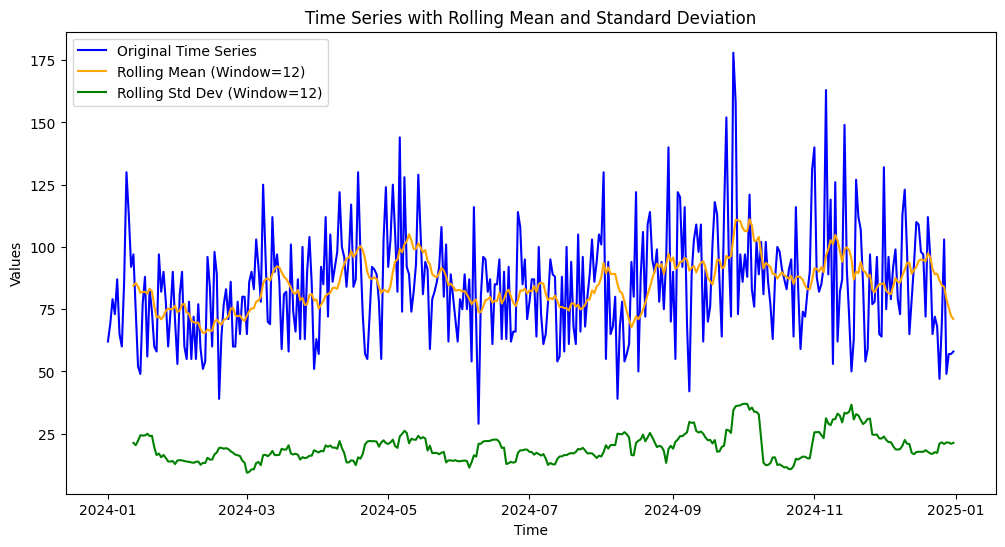

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Calculate rolling mean and rolling standard deviation
rolling_mean = df_crashes.rolling(window=12).mean()
rolling_std = df_crashes.rolling(window=12).std()

# Plot the original series, rolling mean, and rolling standard deviation
plt.figure(figsize=(12, 6))
plt.plot(df_crashes, label='Original Time Series', color='blue')
plt.plot(rolling_mean, label='Rolling Mean (Window=12)', color='orange')
plt.plot(rolling_std, label='Rolling Std Dev (Window=12)', color='green')
plt.title('Time Series with Rolling Mean and Standard Deviation')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()


In [3]:
from statsmodels.tsa.stattools import kpss

# KPSS test function
def kpss_test(series, **kwargs):
    statistic, p_value, n_lags, critical_values = kpss(series, **kwargs)
    print(f"KPSS Statistic: {statistic}")
    print(f"p-value: {p_value}")
    print(f"Number of Lags Used: {n_lags}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"   {key}: {value}")

    # Interpret the results
    if p_value < 0.05:
        print("The series is not stationary (reject null hypothesis).")
    else:
        print("The series is stationary (fail to reject null hypothesis).")

####  Natural Log Transformation
**Observations:**

1. The log-transformed series shows reduced variance compared to the original.
2. High-value fluctuations are compressed, making the series visually smoother.
3. However, minor instability in variance may still persist.

**Insights:**

1. Log transformation is helpful, but it may not fully stabilize variance in cases of extreme fluctuations or skewed data.
2. A more flexible transformation, such as Box-Cox, might provide better results.

####  Box-Cox Transformation
**Observations:**
1. The Box-Cox transformation results in a much smoother time-series compared to both the original and log-transformed series.
2. It effectively handles both skewness and variance fluctuations, making the series ready for stationarity testing.

**Insights:**
1. The Box-Cox transformation is superior when handling both variance and skewness issues.
2. This transformation sets a strong foundation for subsequent steps like seasonal differencing and stationarity testing.

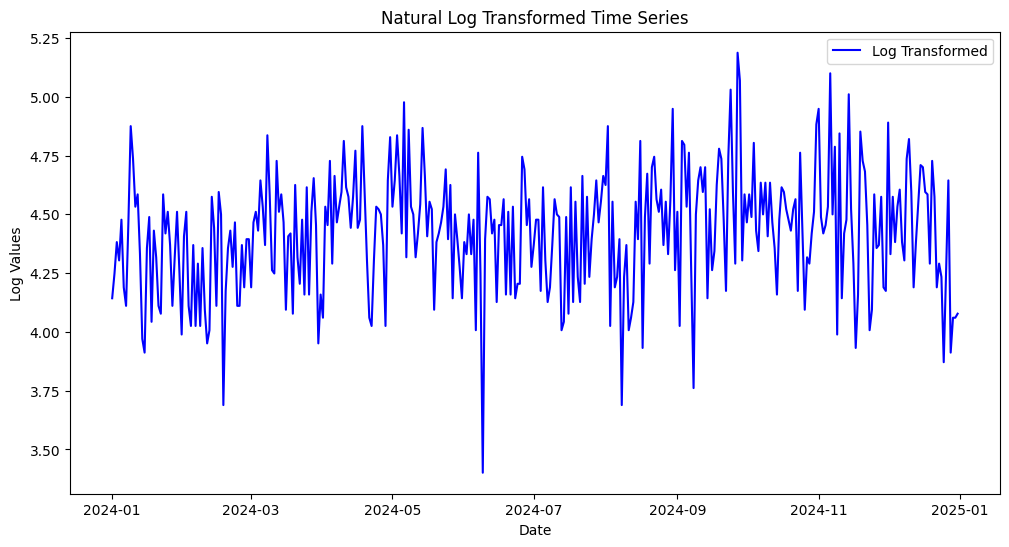

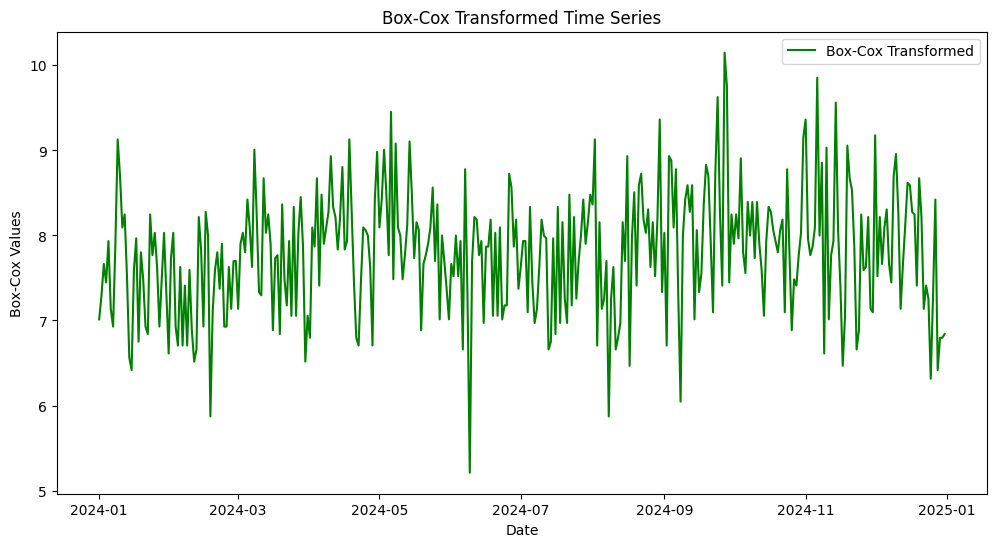

Box-Cox Lambda Value: 0.23513236221942407
KPSS Statistic: 0.6692964506574469
p-value: 0.01633668630386846
Number of Lags Used: 6
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
The series is not stationary (reject null hypothesis).
KPSS Statistic: 0.6931073615378006
p-value: 0.014172058042018125
Number of Lags Used: 6
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
The series is not stationary (reject null hypothesis).


In [4]:
# Access the 'cpd_crashes' column
crash_data = df_crashes['cpd_crashes']

# Shift data to make it positive (if required)
shifted_data = crash_data + 1  # +1 in case of log(0) or Box-Cox issues

# Log Transformation
log_transformed = np.log(shifted_data)

# Box-Cox Transformation
boxcox_transformed, lambda_val = boxcox(shifted_data)

# Plot the transformations
plt.figure(figsize=(12, 6))
plt.plot(log_transformed, label='Log Transformed', color='blue')
plt.title('Natural Log Transformed Time Series')
plt.xlabel('Date')
plt.ylabel('Log Values')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(pd.Series(boxcox_transformed, index=crash_data.index), label='Box-Cox Transformed', color='green')
plt.title('Box-Cox Transformed Time Series')
plt.xlabel('Date')
plt.ylabel('Box-Cox Values')
plt.legend()
plt.show()

# Print Lambda Value for Box-Cox
print(f"Box-Cox Lambda Value: {lambda_val}")
kpss_test(log_transformed)
kpss_test(boxcox_transformed)



In [5]:
print("Variance of Original Series:", np.var(crash_data))
print("Variance of Log-Transformed Series:", np.var(log_transformed))
print("Variance of Box-Cox-Transformed Series:", np.var(boxcox_transformed))

from scipy.stats import skew
print("Skewness of Original Series:", skew(crash_data))
print("Skewness of Log-Transformed Series:", skew(log_transformed))
print("Skewness of Box-Cox-Transformed Series:", skew(boxcox_transformed))


Variance of Original Series: 478.994057750306
Variance of Log-Transformed Series: 0.06519242211578695
Variance of Box-Cox-Transformed Series: 0.5185020966191669
Skewness of Original Series: 0.688670992713343
Skewness of Log-Transformed Series: -0.20564419991177815
Skewness of Box-Cox-Transformed Series: 0.006554205756116772


####  Seasonal Differencing
**Observations:**

1. After seasonal differencing (lag=7 for weekly seasonality), the series now fluctuates around a stable mean.
2. The cyclic pattern is minimized, suggesting seasonality has been removed.

**Insights:**

1. The removal of seasonality improves the series' stationarity, making it suitable for modeling.
2. You can now assess whether the series is fully stationary using statistical tests.


####  Interpretation of KPSS Test Results

**Insights:**

1. The series is stationary after applying seasonal differencing. No further differencing or transformations are needed.
2. This means the data is now suitable for time-series modeling, such as ARIMA, SARIMA, or any other forecasting models.

In [6]:
# boxcox_transformed_series = pd.Series(boxcox_transformed, index=crash_data.index)
# # Seasonal differencing (assuming seasonality is daily for a 7-day cycle, adjust for your data's frequency)
# seasonal_diff_box_cox = boxcox_transformed - boxcox_transformed_series.shift(7)  # Subtract the value 7 days earlier (weekly seasonality)

# # Drop NaN values resulting from differencing
# seasonal_diff_box_cox = seasonal_diff_box_cox.dropna()

# # Plot the seasonally differenced series
# plt.figure(figsize=(12, 6))
# plt.plot(seasonal_diff_box_cox, label='Seasonally Differenced (Lag=7)', color='purple')
# plt.title('Seasonally Differenced Time Series')
# plt.xlabel('Date')
# plt.ylabel('Values')
# plt.legend()
# plt.show()

# # Reassess stationarity
# print("Seasonal Differencing Results:")
# kpss_test(seasonal_diff_box_cox)

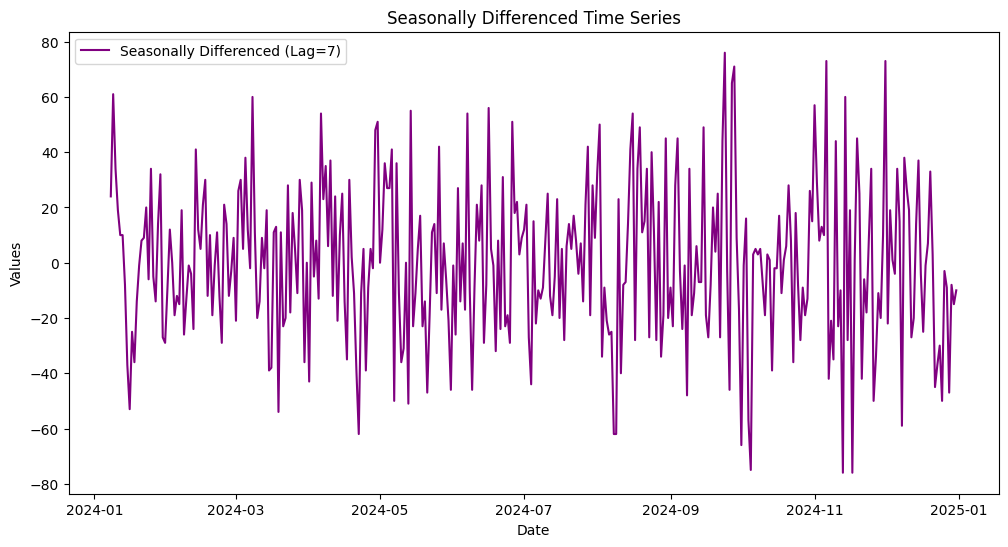

Seasonal Differencing Results:
KPSS Statistic: 0.07616790436503462
p-value: 0.1
Number of Lags Used: 3
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
The series is stationary (fail to reject null hypothesis).


C:\Users\siddh\AppData\Local\Temp\ipykernel_6612\1660811673.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kwargs)


In [7]:
# Seasonal differencing (assuming seasonality is daily for a 7-day cycle, adjust for your data's frequency)
seasonal_diff = crash_data - crash_data.shift(7)  # Subtract the value 7 days earlier (weekly seasonality)

# Drop NaN values resulting from differencing
seasonal_diff = seasonal_diff.dropna()

# Plot the seasonally differenced series
plt.figure(figsize=(12, 6))
plt.plot(seasonal_diff, label='Seasonally Differenced (Lag=7)', color='purple')
plt.title('Seasonally Differenced Time Series')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

# Reassess stationarity
print("Seasonal Differencing Results:")
kpss_test(seasonal_diff)


In [8]:
# from scipy.special import inv_boxcox
# lambda_val = 0.2454495953441253
# fitted_values_original_scale = inv_boxcox(seasonal_diff, lambda_val)

# plt.figure(figsize=(12, 6))
# plt.plot(seasonal_diff, label='Seasonally Differenced (Lag=7)', color='purple')
# plt.title('Seasonally Differenced Time Series')
# plt.xlabel('Date')
# plt.ylabel('Values')
# plt.legend()
# plt.show()

# # Reassess stationarity
# print("Seasonal Differencing Results:")
# kpss_test(seasonal_diff)


## Section-2

#### ACF and PACF Plots
**Autoregressive Process (AR), Moving Average Process (MA), or Combined (ARMA):**
**ACF Plot Analysis:**

1. There is a significant negative spike at lag 7, suggesting a seasonal moving average (SMA) component.
2. The ACF decays gradually (but not sharply) after the initial spikes, indicating the presence of both an MA and seasonal components.

**PACF Plot Analysis:**

1. There is a significant spike at lag 1 in the PACF, which suggests a strong AR(1) component.
2. The PACF at seasonal lags (e.g., lag 7) also shows significant spikes, indicating the need for a seasonal AR (SAR) component.

**Conclusion:**

Based on the gradual decay in ACF and PACF patterns, the process is likely a combination of autoregressive and moving average components, with additional seasonal behavior.

**Order of the Time-Series (ARIMA Model):**

Using the ACF/PACF plots:

1. For the non-seasonal ARIMA terms:
- 𝑝=1(significant spike in PACF at lag 1 indicates AR(1)).
- q=1 (gradual decay in ACF suggests MA(1)).
2. For the differencing order (𝑑):
- If the data is stationary after seasonal differencing,𝑑=1
3. Suggested non-seasonal model: ARIMA(1, 1, 1).


**Seasonal ARIMA Effects (SARIMA - PDQ):**

1. Seasonal Differencing (D):
- Seasonal differencing was applied (seasonal lag = 7), so 𝐷=1
2. Seasonal AR (P):
- The PACF shows a significant spike at lag 7, suggesting a seasonal AR(1) (P=1).
3. Seasonal MA (Q):
- The ACF shows a significant spike at lag 7, suggesting a seasonal MA(1) (𝑄=1).
4. Suggested seasonal component: (1, 1, 1, 7).

Overall Suggested Model:
Based on the ACF/PACF plots and stationarity considerations, a possible SARIMA model is:
**SARIMA(1,1,1)(1,1,1,7)**

<Figure size 1200x600 with 0 Axes>

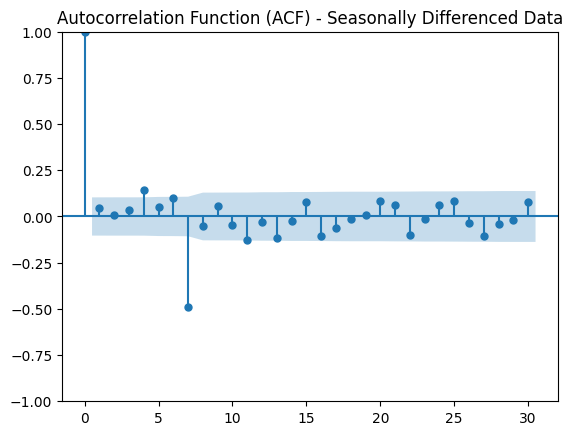

<Figure size 1200x600 with 0 Axes>

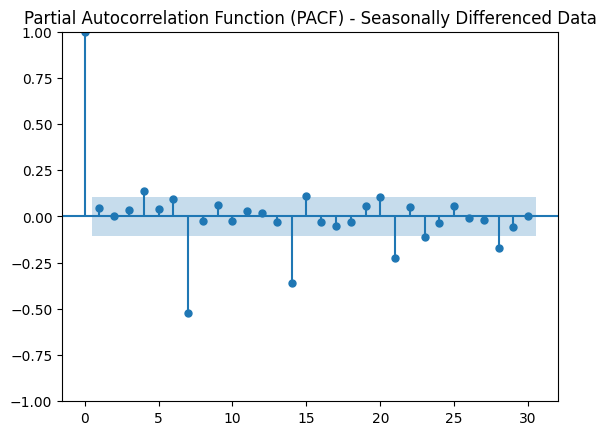

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF for the seasonally differenced data
plt.figure(figsize=(12, 6))
plot_acf(seasonal_diff, lags=30, alpha=0.05)
plt.title('Autocorrelation Function (ACF) - Seasonally Differenced Data')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(seasonal_diff, lags=30, alpha=0.05, method='ywm')
plt.title('Partial Autocorrelation Function (PACF) - Seasonally Differenced Data')
plt.show()


In [10]:
# ! pip uninstall numpy pmdarima
# ! pip install numpy pmdarima

## Section-3

#### Model Selection
1. Best Model According to AIC and BIC:

Model ((2, 1, 2), (1, 1, 1, 7)):
AIC = 3201.447
BIC = 3228.270
This model has the lowest AIC and BIC values, making it the best candidate among the manually tested models.

2. **Automated ARIMA was having compatibility issues with python and numpy version**

- SARIMA selects a different model, it likely means:
- The automated process found a model with lower AIC/BIC by exploring a broader parameter range.
- The data’s stationarity, seasonality, or autocorrelation structure led the SARIMA function to prioritize a simpler or more complex model.

3. Fitted Values and Trends:

From the plot:
- Fitted values (red dashed line) generally follow the overall trends in the observed values (black line).
- Some deviations exist, especially during periods of high variability, indicating room for improvement in capturing certain dynamics of the data.
- Seasonality and trends are captured well, suggesting the model is effective in identifying both short-term and seasonal patterns.

C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCac

All Models' Results:
Model ((1, 1, 1), (1, 1, 1, 7)): AIC = 3208.6924285335112, BIC = 3227.8664822188243
Model ((1, 1, 0), (1, 1, 0, 7)): AIC = 3581.77967557667, BIC = 3593.292866918168
Model ((0, 1, 1), (0, 1, 1, 7)): AIC = 3296.460737095008, BIC = 3307.965169306196
Model ((2, 1, 2), (1, 1, 1, 7)): AIC = 3201.4472670839377, BIC = 3228.2704444249225

Best Model:
Parameters: ((2, 1, 2), (1, 1, 1, 7))
AIC: 3201.4472670839377
BIC: 3228.2704444249225


C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


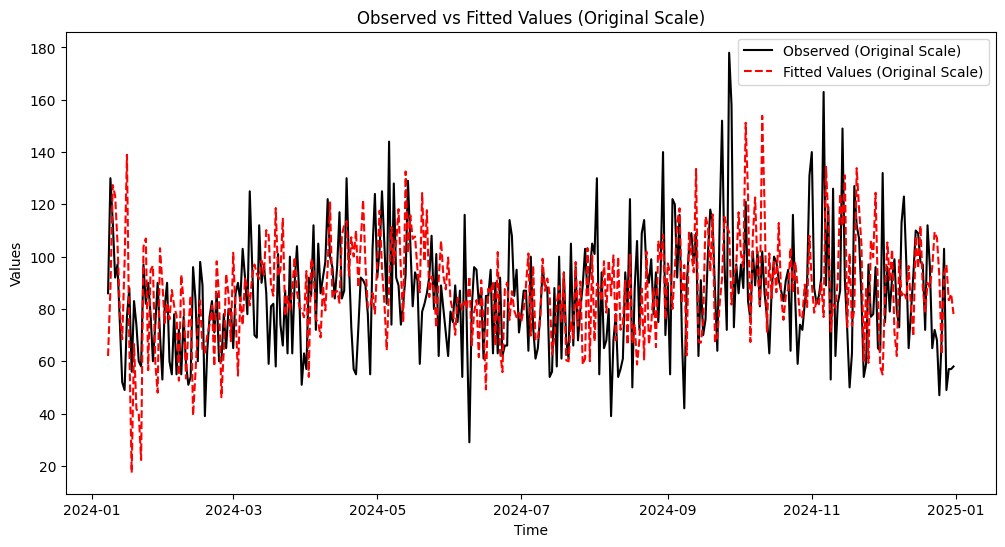

In [ ]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Function to fit and evaluate ARIMA/SARIMA models
# def fit_arima_models(data, param_grid, seasonal_lag=None):
#     results = {}
#     for params in param_grid:
#         try:
#             model = SARIMAX(data,
#                             order=params['order'],
#                             seasonal_order=params['seasonal_order'],
#                             enforce_stationarity=False,
#                             enforce_invertibility=False)
#             result = model.fit(disp=False)
#             results[(params['order'], params['seasonal_order'])] = {
#                 'model': result,
#                 'aic': result.aic,
#                 'bic': result.bic
#             }
#         except Exception as e:
#             results[(params['order'], params['seasonal_order'])] = {'error': str(e)}
#     return results

# # Define a parameter grid for manual ARIMA/SARIMA testing
# param_grid = [
#     {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 7)},
#     {'order': (1, 1, 0), 'seasonal_order': (1, 1, 0, 7)},
#     {'order': (0, 1, 1), 'seasonal_order': (0, 1, 1, 7)},
#     {'order': (2, 1, 2), 'seasonal_order': (1, 1, 1, 7)}
# ]

# # Fit and evaluate models
# results = fit_arima_models(seasonal_diff, param_grid)

# # Print all model results
# print("All Models' Results:")
# for key, value in results.items():
#     if 'error' in value:
#         print(f"Model {key}: Error - {value['error']}")
#     else:
#         print(f"Model {key}: AIC = {value['aic']}, BIC = {value['bic']}")

# # Find the best model based on AIC
# best_model_key = min(
#     results.keys(), 
#     key=lambda k: results[k]['aic'] if 'aic' in results[k] else float('inf')
# )
# best_model = results[best_model_key]

# # Print the best model's information
# print("\nBest Model:")
# print(f"Parameters: {best_model_key}")
# print(f"AIC: {best_model['aic']}")
# print(f"BIC: {best_model['bic']}")

# # Get fitted values
# fitted_values = best_model['model'].fittedvalues

# # Reconstruct the original scale for observed and fitted values
# # Add seasonal lag back to the differenced data to reconstruct the original scale
# seasonal_lag = 7  # Adjust based on your data's seasonality (e.g., 12 for monthly)
# reconstructed_observed = seasonal_diff + crash_data.shift(seasonal_lag)
# reconstructed_observed = reconstructed_observed.dropna()

# reconstructed_fitted = fitted_values + crash_data.shift(seasonal_lag)
# reconstructed_fitted = reconstructed_fitted.dropna()

# # Plot observed vs fitted values in the original scale
# plt.figure(figsize=(12, 6))
# plt.plot(reconstructed_observed, label="Observed (Original Scale)", color="black")
# plt.plot(reconstructed_fitted, label="Fitted Values (Original Scale)", linestyle="--", color="red")
# plt.legend()
# plt.title("Observed vs Fitted Values (Original Scale)")
# plt.xlabel("Time")
# plt.ylabel("Values")
# plt.show()


C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCac

All Models' Results:
Model ((1, 1, 1), (1, 1, 1, 7)): AIC = 3208.6924285335112, BIC = 3227.8664822188243
Model ((1, 1, 0), (1, 1, 0, 7)): AIC = 3581.77967557667, BIC = 3593.292866918168
Model ((0, 1, 1), (0, 1, 1, 7)): AIC = 3296.460737095008, BIC = 3307.965169306196
Model ((2, 1, 2), (1, 1, 1, 7)): AIC = 3201.4472670839377, BIC = 3228.2704444249225

Best Model:
Parameters: ((2, 1, 2), (1, 1, 1, 7))
AIC: 3201.4472670839377
BIC: 3228.2704444249225


C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


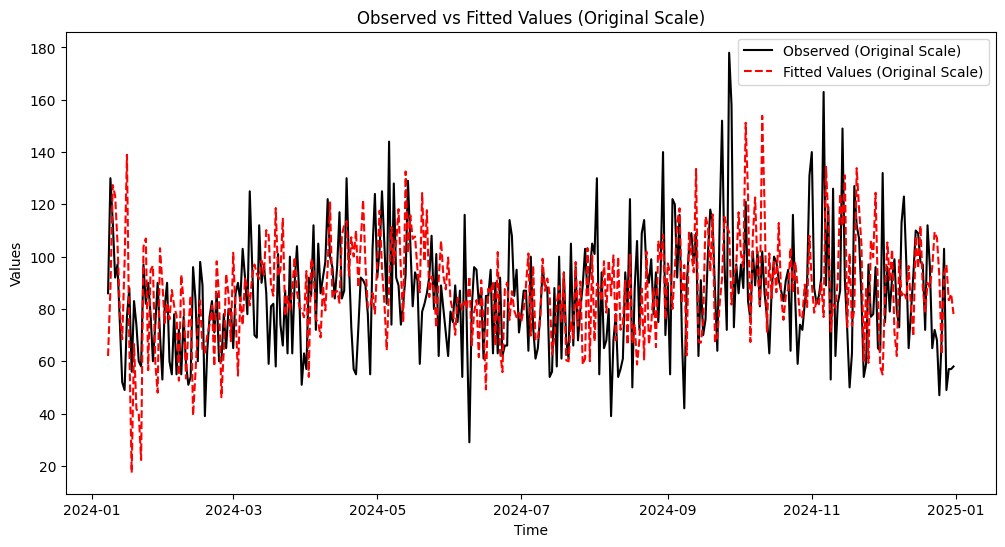

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to fit and evaluate ARIMA/SARIMA models
def fit_arima_models(data, param_grid, seasonal_lag=None):
    results = {}
    for params in param_grid:
        try:
            model = SARIMAX(data,
                            order=params['order'],
                            seasonal_order=params['seasonal_order'],
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            result = model.fit(disp=False)
            results[(params['order'], params['seasonal_order'])] = {
                'model': result,
                'aic': result.aic,
                'bic': result.bic
            }
        except Exception as e:
            results[(params['order'], params['seasonal_order'])] = {'error': str(e)}
    return results

# Define a parameter grid for manual ARIMA/SARIMA testing
param_grid = [
    {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 7)},
    {'order': (1, 1, 0), 'seasonal_order': (1, 1, 0, 7)},
    {'order': (0, 1, 1), 'seasonal_order': (0, 1, 1, 7)},
    {'order': (2, 1, 2), 'seasonal_order': (1, 1, 1, 7)}
]

# Fit and evaluate models
results = fit_arima_models(seasonal_diff, param_grid)

# Print all model results
print("All Models' Results:")
for key, value in results.items():
    if 'error' in value:
        print(f"Model {key}: Error - {value['error']}")
    else:
        print(f"Model {key}: AIC = {value['aic']}, BIC = {value['bic']}")

# Find the best model based on AIC
best_model_key = min(
    results.keys(), 
    key=lambda k: results[k]['aic'] if 'aic' in results[k] else float('inf')
)
best_model = results[best_model_key]

# Print the best model's information
print("\nBest Model:")
print(f"Parameters: {best_model_key}")
print(f"AIC: {best_model['aic']}")
print(f"BIC: {best_model['bic']}")

# Get fitted values
fitted_values = best_model['model'].fittedvalues

# Reconstruct the original scale for observed and fitted values
# Add seasonal lag back to the differenced data to reconstruct the original scale
seasonal_lag = 7  # Adjust based on your data's seasonality (e.g., 12 for monthly)
reconstructed_observed = seasonal_diff + crash_data.shift(seasonal_lag)
reconstructed_observed = reconstructed_observed.dropna()

reconstructed_fitted = fitted_values + crash_data.shift(seasonal_lag)
reconstructed_fitted = reconstructed_fitted.dropna()

# Plot observed vs fitted values in the original scale
plt.figure(figsize=(12, 6))
plt.plot(reconstructed_observed, label="Observed (Original Scale)", color="black")
plt.plot(reconstructed_fitted, label="Fitted Values (Original Scale)", linestyle="--", color="red")
plt.legend()
plt.title("Observed vs Fitted Values (Original Scale)")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()


## Section-4

#### Perfromace Analysis of Model

**Residuals Plot (Figure 1):**

1. The residuals fluctuate around the zero line, but there are periods of higher variability, suggesting that the variance is not completely uniform.
2. This indicates that while the model captures most patterns in the data, there might still be some structure (e.g., autocorrelation) left in the residuals.

**ACF and PACF of Residuals (Figures 2 and 3):**

1. ACF: The ACF shows some spikes outside the confidence interval at lag 7, which is significant and indicates possible remaining seasonal autocorrelation in the residuals.
2. PACF: The PACF also exhibits some significant spikes, suggesting that the residuals may still contain some structure.
Ljung-Box Test Results (Table):
- Forlag≤4, the p-values are >0.05, suggesting the residuals are uncorrelated at these lags.
- However, for lag≥5, the p-values drop significantly (p<0.05), indicating significant autocorrelation remains in the residuals.

**Forecast:**

1. The values show variability and seasonal fluctuations, which is consistent with the historical data.
2. The forecast shows an upward trend followed by a drop, reflecting the historical seasonality and variability.
3. The forecast is reasonable because it aligns with historical seasonal patterns, but the high variability might indicate residual issues that could slightly impact forecast reliability.


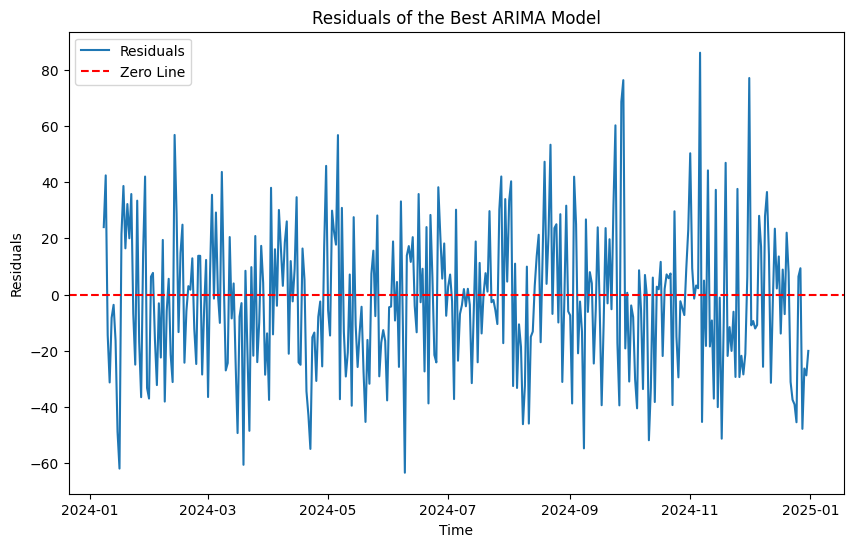

<Figure size 1000x600 with 0 Axes>

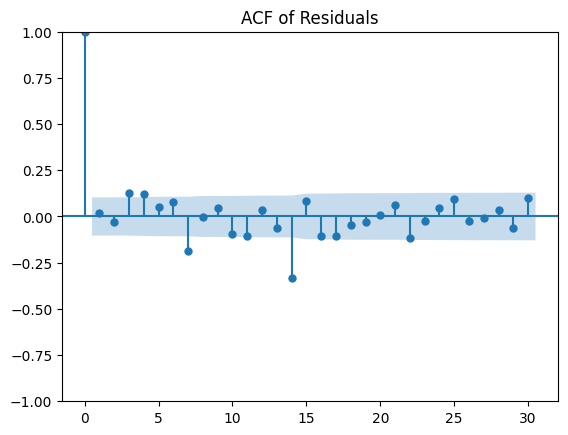

<Figure size 1000x600 with 0 Axes>

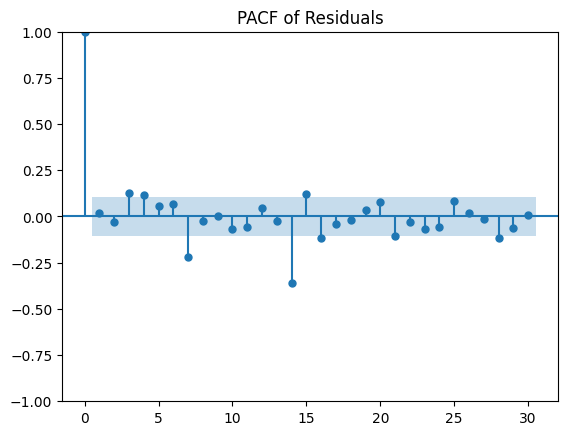

C:\Users\siddh\AppData\Local\Temp\ipykernel_6612\3046880903.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_original_scale[i] = forecast[i] + last_original_values[i % seasonal_lag]


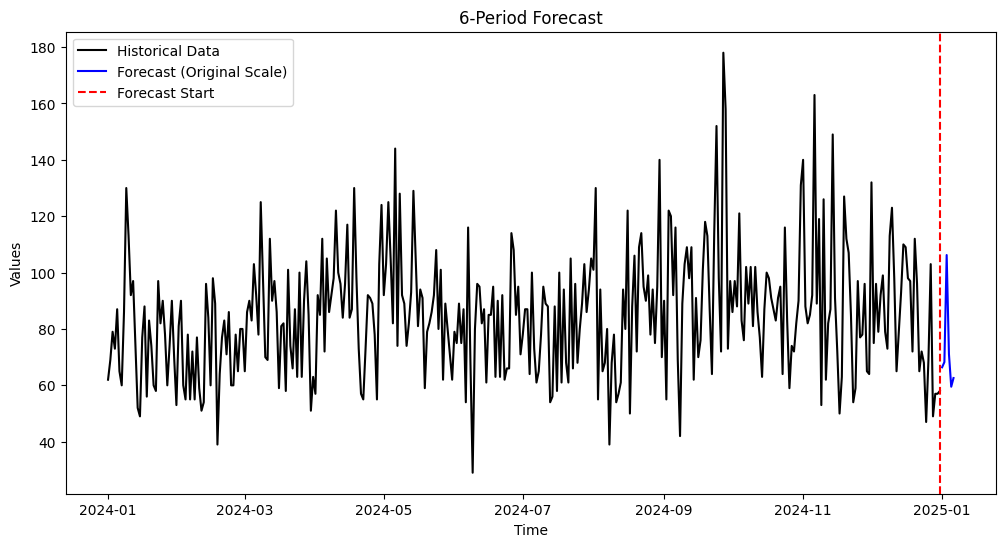

,lb_stat,lb_pvalue
1,0.115810,0.733624
2,0.397207,0.819875
3,6.067970,0.108350
4,11.341542,0.022982
5,12.232061,0.031743
6,14.341051,0.026050
7,26.952845,0.000340
8,26.956167,0.000719
9,27.769480,0.001042
10,31.127417,0.000559


,Forecast Time Period,Forecast Values
0,1,66.405120
1,2,68.246755
2,3,106.226610
3,4,71.088998
4,5,59.518234
5,6,62.590063


In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import pandas as pd

# Extract residuals from the best ARIMA model
residuals = best_model['model'].resid
residuals.index = seasonal_diff.index  # Align residuals with the original index

# Step 1: Plot Residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Line")
plt.title("Residuals of the Best ARIMA Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend()
plt.show()

# Step 2: Conduct a Box-Ljung Test (Range of Lags)
ljung_box_result = acorr_ljungbox(residuals, lags=10, return_df=True)

# Step 3: Plot ACF and PACF for Residuals
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=30, alpha=0.05)
plt.title("ACF of Residuals")
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(residuals, lags=30, alpha=0.05)
plt.title("PACF of Residuals")
plt.show()

# Step 4: Check Residuals as White Noise
white_noise = "Yes" if (ljung_box_result['lb_pvalue'].values[-1] > 0.05) else "No"

# Step 5: Create a 6-time-period forecast
forecast_steps = 6
forecast_result = best_model['model'].get_forecast(steps=forecast_steps)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()


seasonal_lag = 7  # Seasonal lag used in differencing

# Reconstruct the original scale for the forecast
forecast_original_scale = np.zeros(forecast_steps)
last_original_values = crash_data.iloc[-seasonal_lag:].values

for i in range(forecast_steps):
    forecast_original_scale[i] = forecast[i] + last_original_values[i % seasonal_lag]

# Create a date range for the forecast
forecast_dates = pd.date_range(start=crash_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq=crash_data.index.freq)

# Convert numpy arrays to pandas Series with a DatetimeIndex
forecast_series = pd.Series(forecast_original_scale, index=forecast_dates)

# Step 7: Plot Forecast vs Historical Data
plt.figure(figsize=(12, 6))
plt.plot(crash_data.index, crash_data, label="Historical Data", color="black")
plt.plot(forecast_series.index, forecast_series, label="Forecast (Original Scale)", color="blue")


plt.axvline(x=crash_data.index[-1], color='red', linestyle="--", label="Forecast Start")
plt.legend()
plt.title("6-Period Forecast")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

output = {
'ljung_box_test': ljung_box_result,
'forecast_values': forecast_original_scale}

# Convert Ljung-Box test results into a DataFrame
ljung_box_df = pd.DataFrame(output['ljung_box_test'])

# Convert forecast values into a DataFrame
forecast_df = pd.DataFrame({
    "Forecast Time Period": range(1, len(output['forecast_values']) + 1),
    "Forecast Values": output['forecast_values']
})
display(ljung_box_df)
display(forecast_df)